First , we load the required library, dependences, and appoint path for data input.

In [1]:
import numpy as np
import os
folder_path = r"/home/yesyessp/MLProject/data1"
import numpy as np, tensorflow as tf, time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("Available devices:", tf.config.list_physical_devices())
print(tf.__version__)

2025-05-04 10:06:23.542724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 10:06:23.551206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746367583.560744    1422 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746367583.563603    1422 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746367583.570395    1422 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.19.0


2025-05-04 10:06:25.150801: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Then we load and process the data set.

In [2]:
for filename in os.listdir(folder_path):
  if filename.endswith('.npy'):
    file_path = os.path.join(folder_path, filename)
    try:
      data = np.load(file_path)
      print(f"Found data in {filename}:")
      # print(data)  # Or process the data as needed
    except Exception as e:
      print(f"Error loading {filename}: {e}")
# Load the data collected
TIME = np.load(os.path.join(folder_path, 'TIME.npy'))
U = np.load(os.path.join(folder_path, 'U_data.npy'))
print(U[0,:])
Y = np.load(os.path.join(folder_path, 'Y_matrix.npy'))
delta = Y[:,0:6]*np.pi/180  # Convert degrees to radians
omega = Y[:,6:12]
theta = Y[:,12:12+23]*np.pi/180  # Convert degrees to radians
V = Y[:,12+23:12+23+23]

Y_new = np.hstack((delta, omega, theta, V))
X = np.hstack(( TIME, U))


X_norm = (X - np.mean(X,axis=0))/np.std(X,axis=0)
mu_x = np.mean(X,axis=0)[1:]
sigma_x = np.std(X,axis=0)[1:]
# cast mean and std to float32
mu_x = mu_x.astype(np.float32)
sigma_x = sigma_x.astype(np.float32)
X_norm[:,0]=X[:,0]

Y_norm = (Y_new - np.mean(Y_new,axis=0))/np.std(Y_new,axis=0)
mu_y = np.mean(Y_new,axis=0)
sigma_y = np.std(Y_new,axis=0)
# cast mean and std to float32
mu_y = mu_y.astype(np.float32)
sigma_y = sigma_y.astype(np.float32)

Found data in X_DATA.npy:
Found data in TIME.npy:
Found data in X0.npy:
Found data in Y_matrix.npy:
Found data in U_data.npy:
[ 112.28518545  638.85519599  425.90351815  310.35293964 1264.15612287
  100.50809522  207.49006294  208.58662549  -56.51201767 -510.17009019
 -396.79890906 -160.53156224 -776.84976018  -50.50938217  -80.72274487
  -81.57822972]


Load the trained model PINN_Malik_1.tf

In [3]:
# ============================================================================
# Physics-Informed Neural Network with a dynamic regularisation weight λ(t)
# ============================================================================
import numpy as np, tensorflow as tf, time
from sklearn.model_selection import train_test_split
from tensorflow.keras.saving import register_keras_serializable

# ──────────────────────────────────────────────────────────────────────────────
# Helper: schedule λ(t) during training
# ──────────────────────────────────────────────────────────────────────────────
class LambdaScheduler(tf.keras.callbacks.Callback):
    """
    Linearly ramps λ from λ_min → λ_max over the course of training.
    (Feel free to swap the formula in on_epoch_begin for an exponential,
     cosine, or piece-wise schedule if you prefer.)
    """
    def __init__(self, lam_var: tf.Variable,
                 lam_min: float,
                 lam_max: float,
                 epochs: int):
        super().__init__()
        self.lam_var  = lam_var          # the tf.Variable created inside the trainer
        self.lam_min  = float(lam_min)
        self.lam_max  = float(lam_max)
        self.epochs   = int(epochs)

    def on_epoch_begin(self, epoch, logs=None):
        prog   = epoch / max(1, self.epochs-1)      # 0 → 1
        new_lam = self.lam_min + (prog-0.3) * (self.lam_max - self.lam_min)
        new_lam = max(0.0, new_lam)                 # avoid negative λ
        new_lam = min(self.lam_max, new_lam)         # avoid exceeding λ_max
        self.lam_var.assign(new_lam)                # ← update in-graph variable
        tf.print("λ =", self.lam_var, " (epoch", epoch, ")")

# ──────────────────────────────────────────────────────────────────────────────
# Main trainer
# ──────────────────────────────────────────────────────────────────────────────
class PhysicsNNTrainer:
    # ------------------------------------------------------------------ init
    def __init__(self, X_norm, Y_norm, mu_y, sigma_y,
                 batch_size=64, test_size=0.20,
                 hidden_units=64, n_layers=1,
                 activation='relu',
                 lambda_reg=1,):          # ← λ_max (final value)

        # (1) keep normalisation tensors
        self.mu_y    = tf.constant(mu_y,    tf.float32)
        self.sigma_y = tf.constant(sigma_y, tf.float32)

        # λ will be **mutated** by the callback, so make it a tf.Variable
        self.lambda_r = tf.Variable(0.0, dtype=tf.float32, trainable=False,
                                    name="lambda_reg")   # initialise small

        # (2) deterministic split
        X_tr, X_te, Y_tr, Y_te = train_test_split(
            X_norm, Y_norm, test_size=test_size, shuffle=False)
        
        sample_weights = np.ones(X_tr.shape[0])
        print("size of sample weights: ", sample_weights.shape)  # Start with equal weights
        for i in range(0, X_tr.shape[0], 802):
            sample_weights[i:i+100] = 2  # 


        # (3) identical Dataset pipeline
        def make_ds(x, y,weights= None):
            if weights is None:
                return (tf.data.Dataset
                        .from_tensor_slices((x.astype('f'), y.astype('f')))  # (x, y)
                        .shuffle(10_000)
                        .batch(batch_size)
                        .prefetch(tf.data.AUTOTUNE))
            else:
                return (tf.data.Dataset
                        .from_tensor_slices((x.astype('f'), (y.astype('f'), weights.astype('f')))) # (x, (y, w))
                        .shuffle(10_000)
                        .batch(batch_size)
                        .prefetch(tf.data.AUTOTUNE))
        self.ds_train, self.ds_test = make_ds(X_tr, Y_tr,sample_weights), make_ds(X_te, Y_te)

        # (4) build the model
        self.model = self._build_model(hidden_units, n_layers, activation)

        # remember λ_max so the callback knows where to ramp to
        self.lambda_max = float(lambda_reg)

    # ========================================================== swing eqn ==
    @staticmethod
    def _physics(y_pred):
        Gen_bus = [0, 1, 11, 12, 21, 22]
        V_idx   = [12 + 23 + i for i in Gen_bus]
        th_idx  = [12 + i      for i in Gen_bus]

        H   = tf.constant([36, 36, 25, 36.25, 30, 3.9],  tf.float32)
        D   = tf.constant([90, 90, 100, 72.5, 0, 0],     tf.float32)
        E   = tf.constant([1.07488163, 1.07488163, 1.18653694,
                           1.06655853, 1.07838708, 1.2603447], tf.float32)
        xdp = tf.constant([0.03333, 0.03333, 0.025, 0.03586, 0.035, 0.269], tf.float32)
        Pm  = tf.constant([7.5, 7.5, 8, 6, 2.5863, 1], tf.float32)

        Vg    = tf.gather(y_pred, V_idx, axis=1)
        th_g  = tf.gather(y_pred, th_idx, axis=1)
        delta = y_pred[:, :6]
        omega = y_pred[:, 6:12]

        Pe        = (Vg * E) / xdp * tf.sin(delta - th_g)
        domega_dt = (1 / (2 * H)) * (Pm - Pe - D * omega)
        ddelta_dt = (2 * np.pi * 60.0) * omega
        return tf.concat([ddelta_dt, domega_dt], axis=1)     #  (batch, 12)

    # ---------------------------------------------------------------- model
    def _build_model(self, hidden_units, n_layers, activation):

        mu_y, sigma_y, lam_var = self.mu_y, self.sigma_y, self.lambda_r
        physics_fn = self._physics
        act        = tf.keras.activations.get(activation)
        
        @register_keras_serializable(package='PhysicsNN')
        class PhysNet(tf.keras.Model):
            def __init__(self,**kwargs):
                super().__init__(**kwargs)
                self.hidden = [tf.keras.layers.Dense(hidden_units, activation=act)
                               for _ in range(n_layers)]
                self.out = tf.keras.layers.Dense(58)

            # ---------- forward ------------------------------------------
            def call(self, x):
                for layer in self.hidden:
                    x = layer(x)
                return self.out(x)

            # ---------- training step ------------------------------------
            @tf.function
            def train_step(self, data):
                x, (y, w) = data                    # x: (batch, 17)  y: (batch, 58)

                with tf.GradientTape() as tape:
                    tape.watch(x)
                    y_pred = self(x, training=True)

                    # ----- NN loss (on normalised targets) ---------------
                    base_loss = tf.reduce_mean(tf.abs(y - y_pred) * tf.expand_dims(w, axis=-1))  # Apply weights here

                    # ----- Physics loss ----------------------------------
                    y_pred_act = y_pred @ tf.linalg.diag(sigma_y) + mu_y

                    # dŷ/dt via autodiff on NN
                    GRADS = []
                    for i in range(12):
                        g = tf.gradients(y_pred[:, i], x)[0][:, 0]
                        GRADS.append(g)
                    grad_nn  = tf.reshape(GRADS, (tf.shape(x)[0], 12))

                    # dŷ/dt from swing equations
                    grad_phy = physics_fn(y_pred_act) @ tf.linalg.diag(1/sigma_y[:12])

                    phy_loss = tf.reduce_mean(tf.abs(grad_phy - grad_nn))

                    # total weighted loss  (λ is read **from the Variable**)
                    total_loss = base_loss + lam_var * phy_loss

                # apply gradients
                grads = tape.gradient(total_loss, self.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

                return {"loss":       total_loss,
                        "base_loss":  base_loss,
                        "phy_loss":   phy_loss,
                        "lambda":     lam_var}

        
        # --- Add get_config for saving ---
            # Even though it's nested, Keras needs this when saving the model object
            def get_config(self):
                config = super().get_config()
                # Add any specific config needed to reconstruct THIS PhysNet instance
                # In this nested case, hidden_units, n_layers, activation are
                # captured from the outer scope, so they aren't instance attributes.
                # This might still cause issues with loading if not refactored.
                # A minimal config might be sufficient if layers are saved.
                # config.update({
                #     # Add layer configs if necessary, but Keras usually handles this
                # })
                return config
        
        
        return PhysNet()

# ──────────────────────────────────────────────────────────────────────────────
# Usage
# ──────────────────────────────────────────────────────────────────────────────
#   X_norm, Y_norm, mu_y, sigma_y  : your dataset / normalisation stats
# ----------------------------------------------------------------------------
 

In [ ]:
# model_PINN_MALIK = tf.keras.models.load_model('OF_King_mini.keras') # ver 1 used old data in folder data, ver 2 used new data in folder data1
model_OverFit_KING = tf.keras.models.load_model('OF_King_mini.h5')
#load the best model

trainer = PhysicsNNTrainer(
    X_norm, Y_norm, mu_y, sigma_y,
    batch_size   = 1024,
    hidden_units = 256,
    n_layers     = 4,
    activation   = 'relu',
    lambda_reg   = 0.15)   
model_file = "physics_nn_model_2.keras"
model_PINN_MALIK_fine = tf.keras.models.load_model(model_file)

size of sample weights:  (641600,)


Evaluate the model performance on the test set. 
We compare Vanilla Neural Network (VNN) with Physics Informed Neural Network (PINN) model.



In [8]:
# Evaluate the model
X_tr, X_te, Y_tr, Y_te = train_test_split(
            X_norm, Y_norm, test_size=0.2, shuffle=False)

# loss_Malik = model_PINN_MALIK.evaluate(X_te, Y_te, verbose=1)
loss_Malik_fine = model_PINN_MALIK_fine.evaluate(X_te, Y_te, verbose=1) #this need a different env
loss_King = model_OverFit_KING.evaluate(X_te, Y_te, verbose=1)

# Print the loss
# print(f"Test loss of model_PINN_MALIK: {loss_Malik}")
print(f"Test loss of model_PINN_MALIK_fine: {loss_Malik_fine}")
print(f"Test loss of model_VNN_KING: {loss_King[1]}")

5013/5013 ━━━━━━━━━━━━━━━━━━━━ 3s 672us/step - loss: 0.1521
5013/5013 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0600 - mean_absolute_error: 0.1329
Test loss of model_PINN_MALIK_fine: 0.14021781086921692
Test loss of model_VNN_KING: 0.1438291221857071


Finally, we plot the results to visualize the predictions and compare them with the true values.


6
(802, 17)
(802, 58)
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


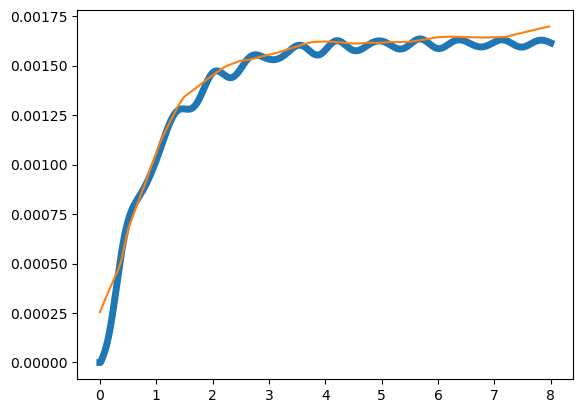

In [9]:
case_num = 805
Ngen = 6
Nbus = 23
# delta --> var_plot = 1
# omega --> var_plot = 2
# theta --> var_plot = 3
#   V   --> var_plot = 4
var_plot = 2
 
gen_plot = 1
bus_plot = 1
 
 
idx = (var_plot==1)*(gen_plot-1) + (var_plot==2)*(gen_plot+Ngen-1) + (var_plot==3)*(bus_plot+2*Ngen-1) + (var_plot==4)*(bus_plot+2*Ngen+Nbus-1)
print(idx)
X_plot = X_norm[802*(case_num-1):802*case_num,:];
Y_plot = Y_norm[802*(case_num-1):802*case_num,:];
 
print(X_plot.shape)
print(Y_plot.shape)
 
time = TIME[:802]
Y_pred = model_PINN_MALIK_fine.predict(X_plot)
# Y_pred = Y_pred*sigma_y+mu_y
y = Y_plot[:,idx]*sigma_y[idx] + mu_y[idx]  # Rescale the output
# y = Y_plot[:,idx]
plt.plot(time,y,linewidth=5)
plt.plot(time[0:799],Y_pred[0:799,idx]*sigma_y[idx] + mu_y[idx])
# plt.plot(time[0:100],np.mean(Y_plot,axis=0)[10]*np.ones(time.shape))
plt.show()
# Y_pred = np.zeros((0,57))

35
(802, 17)
(802, 58)
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


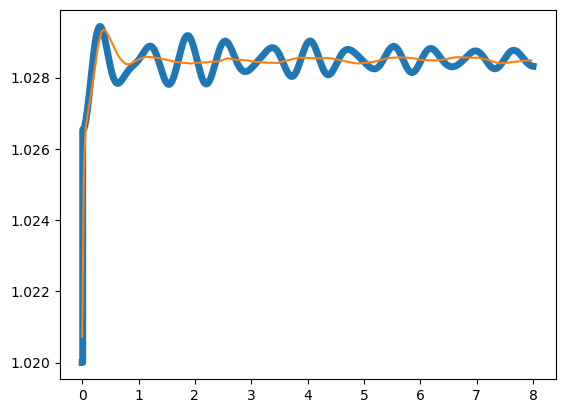

In [18]:
case_num = 805
Ngen = 6
Nbus = 23
# delta --> var_plot = 1
# omega --> var_plot = 2
# theta --> var_plot = 3
#   V   --> var_plot = 4
var_plot = 4
 
gen_plot = 1
bus_plot = 1
 
 
idx = (var_plot==1)*(gen_plot-1) + (var_plot==2)*(gen_plot+Ngen-1) + (var_plot==3)*(bus_plot+2*Ngen-1) + (var_plot==4)*(bus_plot+2*Ngen+Nbus-1)
print(idx)
X_plot = X_norm[802*(case_num-1):802*case_num,:];
Y_plot = Y_norm[802*(case_num-1):802*case_num,:];
 
print(X_plot.shape)
print(Y_plot.shape)
 
time = TIME[:802]
Y_pred = model_OverFit_KING.predict(X_plot)
# Y_pred = Y_pred*sigma_y+mu_y
y = Y_plot[:,idx]*sigma_y[idx] + mu_y[idx]  # Rescale the output
# y = Y_plot[:,idx]
plt.plot(time,y,linewidth=5)
plt.plot(time[0:799],Y_pred[0:799,idx]*sigma_y[idx] + mu_y[idx])
# plt.plot(time[0:100],np.mean(Y_plot,axis=0)[10]*np.ones(time.shape))
plt.show()
# Y_pred = np.zeros((0,57))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
26/26 ━━━━━━━━━━

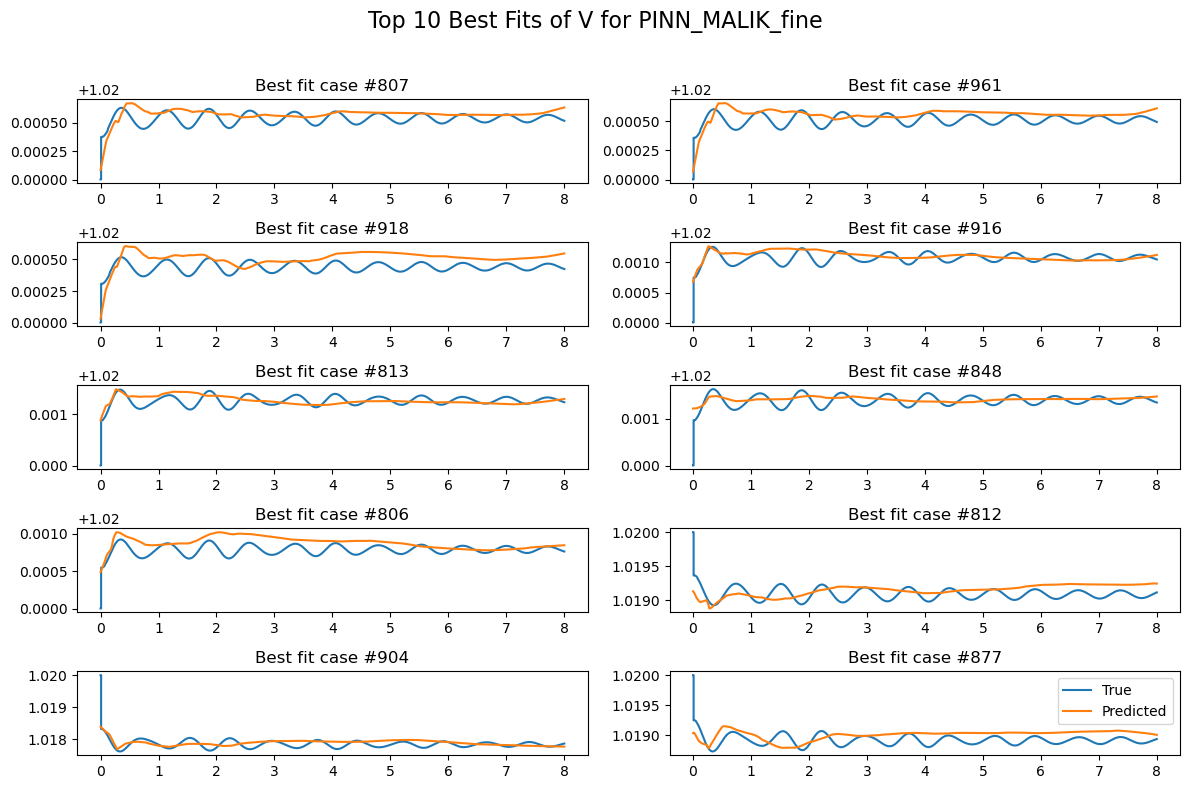

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


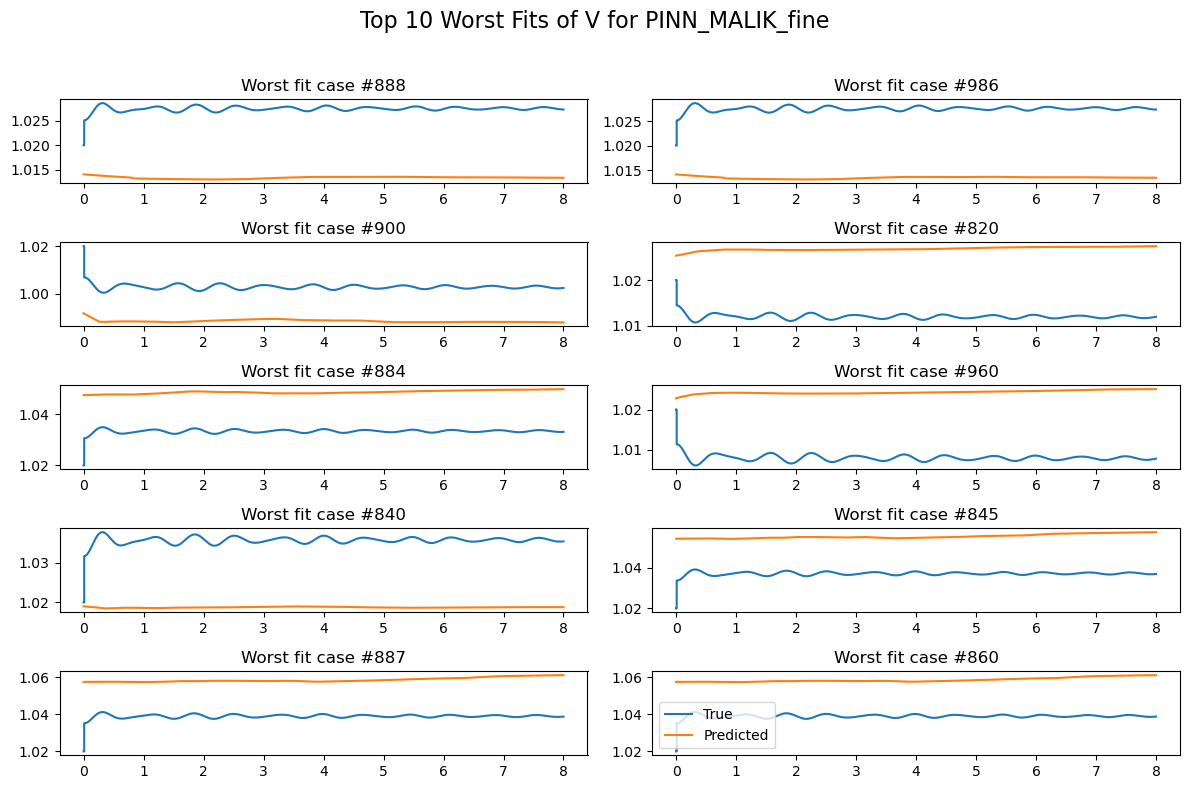

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


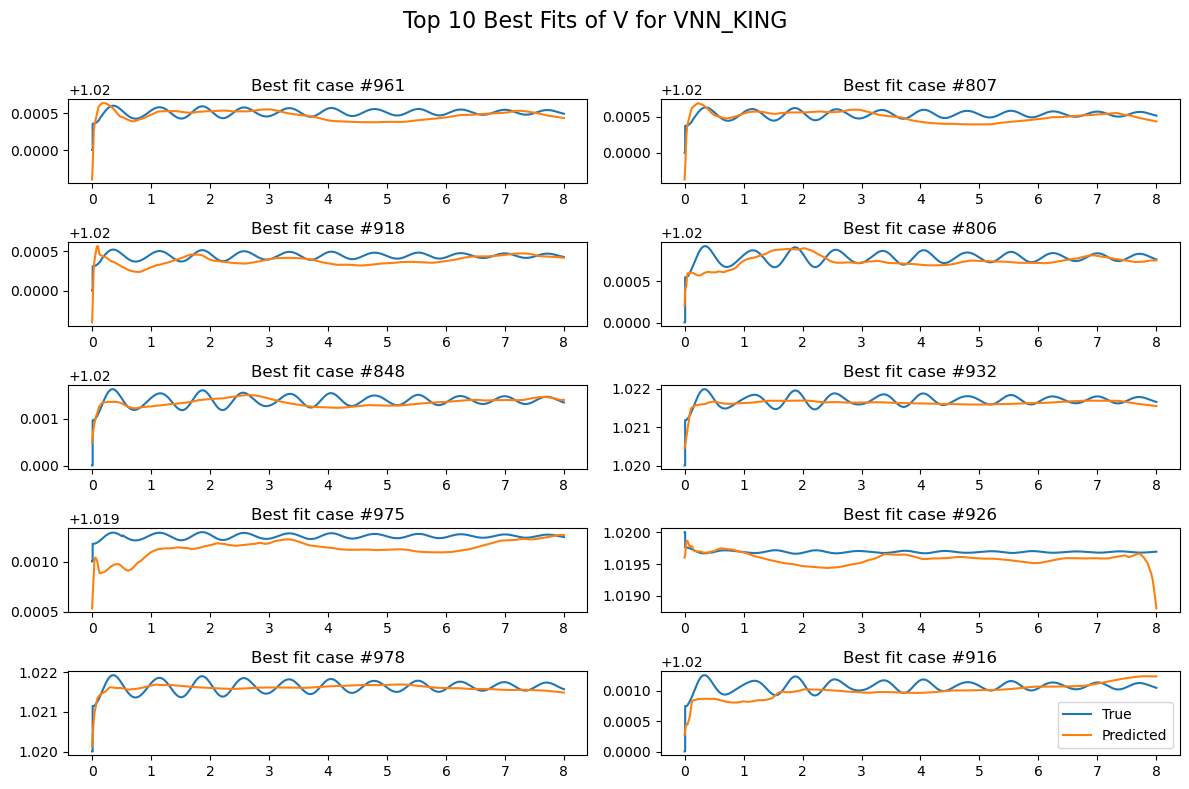

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


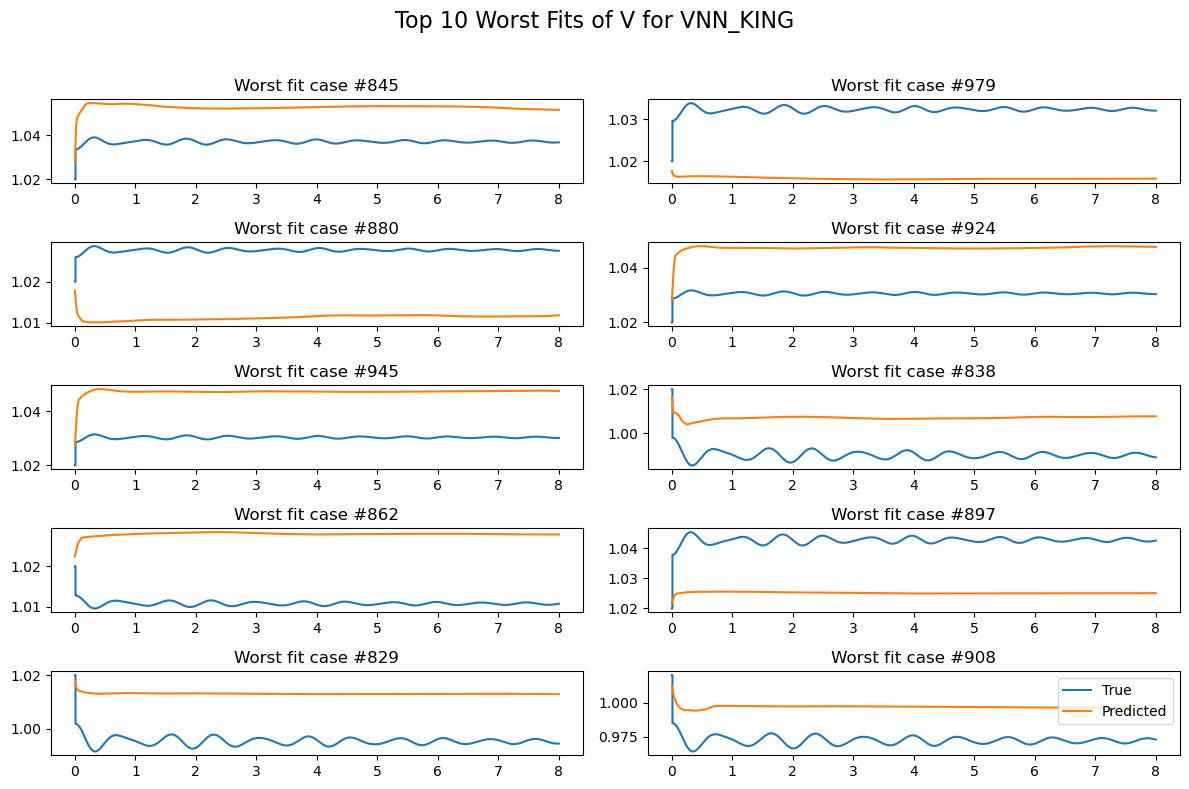

In [19]:
import numpy as np
import matplotlib.pyplot as plt

for model in [model_PINN_MALIK_fine, model_OverFit_KING]:
    if model == model_PINN_MALIK_fine:
        modelname = "PINN_MALIK_fine"
    else:
        modelname = "VNN_KING"

    if var_plot == 1:
        varname = "delta"
    elif var_plot == 2:
        varname = "omega"
    elif var_plot == 3:
        varname = "theta"
    elif var_plot == 4:
        varname = "V"
    else:
        varname = "unknown"
        
    Ncases = Y.shape[0] // 802
    errors = []

    # Compute prediction errors for all cases
    for case in range(800, 1000): # 1000 cases in total 
        X_plot = X_norm[802*(case-1):802*case, :]
        Y_plot_case = Y[802*(case-1):802*case, :]

        Y_pred_case = model.predict(X_plot)
        Y_pred_case = Y_pred_case * sigma_y + mu_y

        error = np.mean((Y_pred_case[:, idx] - Y_plot_case[:, idx])**2)
        errors.append((case, error))

    # Sort by error
    errors_sorted = sorted(errors, key=lambda x: x[1])
    best_cases = [e[0] for e in errors_sorted[:10]]
    worst_cases = [e[0] for e in errors_sorted[-10:]]

    # Plot best fits
    plt.figure(figsize=(12, 8))
    for i, case in enumerate(best_cases):
        X_plot = X_norm[802*(case-1):802*case, :]
        Y_plot_case = Y[802*(case-1):802*case, :]
        time = X_plot[:, 0]

        Y_pred_case = model.predict(X_plot)
        Y_pred_case = Y_pred_case * sigma_y + mu_y

        plt.subplot(5, 2, i+1)
        plt.plot(time, Y_plot_case[:, idx], label='True')
        plt.plot(time, Y_pred_case[:, idx], label='Predicted')
        plt.title(f'Best fit case #{case}')
        plt.tight_layout()
    plt.legend()
    plt.suptitle(f'Top 10 Best Fits of {varname} for {modelname}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plot worst fits
    plt.figure(figsize=(12, 8))
    for i, case in enumerate(worst_cases):
        X_plot = X_norm[802*(case-1):802*case, :]
        Y_plot_case = Y[802*(case-1):802*case, :]
        time = X_plot[:, 0]

        Y_pred_case = model.predict(X_plot)
        Y_pred_case = Y_pred_case * sigma_y + mu_y

        plt.subplot(5, 2, i+1)
        plt.plot(time, Y_plot_case[:, idx], label='True')
        plt.plot(time, Y_pred_case[:, idx], label='Predicted')
        plt.title(f'Worst fit case #{case}')
        plt.tight_layout()
    plt.legend()
    plt.suptitle(f'Top 10 Worst Fits of {varname} for {modelname}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
